In [4]:
from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import random

from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm



prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "b2_stduser_beamports_blm_tracy_corr_with_nlk.lat"   #file provided
         #Note, this file is different to the other ones. The other file is more accurate for our application
         #as this isn't that important, we did not update this version
x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


In [11]:
def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp

def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0):
    ps = gtpsa.ss_vect_double(0.0)

    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.y+=mu_y
    ps.py+=mu_py
    return ps


In [12]:
acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

#Description of NLK
nlkfk = acc.find("pkdnl1kr", 0)
nlk_name = nlkfk.name
nlk, nlkf_intp = create_nlk_interpolation(nlk_name)
nlkfk.set_field_interpolator(nlkf_intp)

In [16]:
#calculate how much the px value changes after the NLK

x_list = []
px_list = []

for x in np.linspace(-40e-3,40e-3,400):

    nlkf_intp.set_scale(1.0)
    ps = create_state_space_vector(mu_x=x,mu_px=0,mu_y=0,mu_py=0)    #x px y py   #TO PLOT!

    result = acc.propagate(calc_config, ps, 170,1)   #start at NLK and just go 1 step, to the end of NLK

    x_list.append(ps.x)
    px_list.append(ps.px)

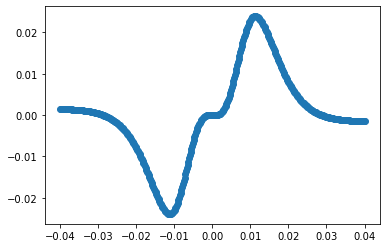

In [17]:
plt.scatter(x_list,px_list)

In [18]:
print(np.max(px_list),np.min(px_list))

0.023893121101031676 -0.023893121101031672


Change of px maximal +- 0.024

### Current px Noise ###
noise_px_sample = np.random.normal($0,.8*6.5e-6$)

99,71% of the data is therefore in (-3 * 0.8 * 6.5e-6, 3 * 0.8 * 6.5e-6) = (-1.56e-05, 1.56e-05)

Upper value of the interval is attained at a kicker strength of

In [23]:
1.56e-05/0.023893121101031676   #use linearity 

0.0006529075851595802

With the activation function around the action it equals around $16\%$

In [28]:
0.0006529075851595802**(1/4)

0.15985010596898355